# Text classification with Pytorch

The goal of this lab are to explore the various way to represent textual data by applying them to a relatively small classification dataset - **20NewsGroup** - and evaluate how they perform on the classification task.
1. Using what we have previously seen, pre-process the data: clean it, obtain an appropriate vocabulary.
2. Obtain representations: any that will allow us to obtain a vector representation of each document is appropriate.
    - Symbolic: **BoW, TF-IDF**
    - Dense document representations: via **Topic Modeling: LSA, LDA**
    - Dense word representations: **SVD-reduced PPMI, Word2vec, GloVe**
        - For these, you will need to implement a **function aggregating word representations into document representations**
3. Perform classification: we can make things simple and only use a **logistic regression**
4. Learn how to use Pytorch for treating textual data, and implement **neural** classification models with Pytorch.

Besides ```torch```, we will use ```gensim``` to obain word embeddings, and ```scikit-learn``` for simple classification models.  

In [1]:
import os.path as op
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint

## I - Simple classifier on top of dense representations

### I.1 Dataset

We're going to work with the **20NewsGroup** data. This dataset is available in ```scikit-learn```, you can find all relevant information in the [documentation](https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html).

In [2]:
from sklearn.datasets import fetch_20newsgroups

In [3]:
# Import training data
ng_train = fetch_20newsgroups(subset='train',
                              remove=('headers', 'footers', 'quotes')
                              )

In [4]:
print("Number of samples:", len(ng_train.data))
print("Number of categories:", len(ng_train.target_names))
print("Categories:", ng_train.target_names[:5], "...")

Number of samples: 11314
Number of categories: 20
Categories: ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware'] ...


In [5]:
print(ng_train.data[0][:1000])  # print first 1000 chars

I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.


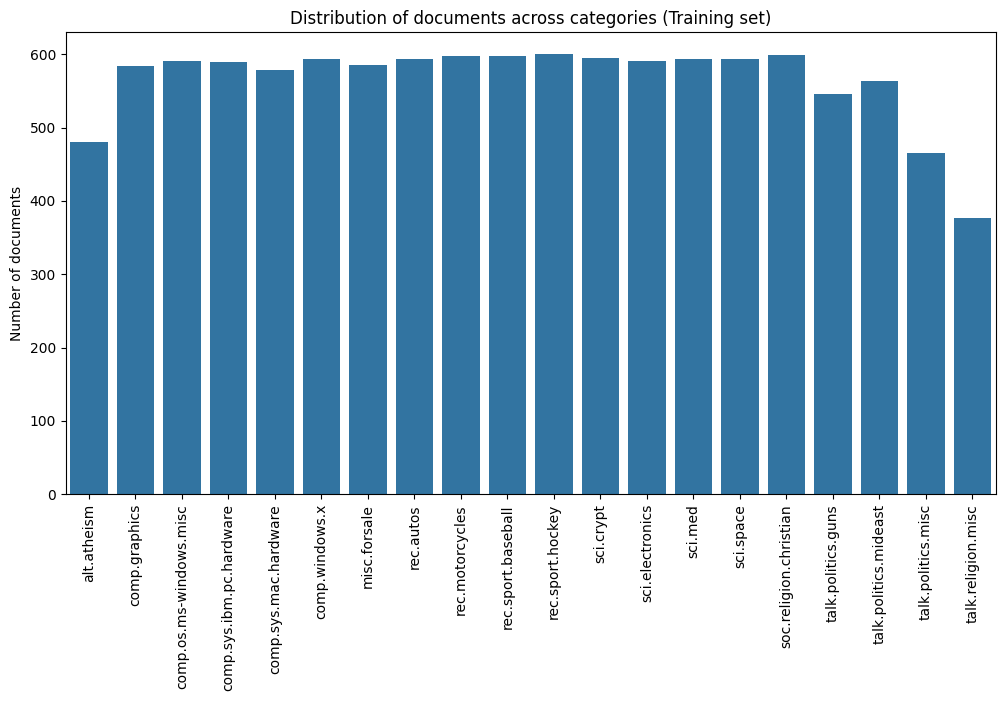

In [36]:
counts = np.bincount(ng_train.target)
plt.figure(figsize=(12,6))
sns.barplot(x=ng_train.target_names, y=counts)
plt.xticks(rotation=90)
plt.ylabel("Number of documents")
plt.title("Distribution of documents across categories (Training set)")
plt.show()

In [6]:
# Let's look at what is in this object
pprint(dir(ng_train))

['DESCR', 'data', 'filenames', 'target', 'target_names']


In [7]:
# Let's look at the categories
pprint(ng_train.target_names)

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']


In [8]:
# .. and the data itself
pprint(ng_train.data[0])
print("Target: ", ng_train.target_names[ng_train.target[0]])

('I was wondering if anyone out there could enlighten me on this car I saw\n'
 'the other day. It was a 2-door sports car, looked to be from the late 60s/\n'
 'early 70s. It was called a Bricklin. The doors were really small. In '
 'addition,\n'
 'the front bumper was separate from the rest of the body. This is \n'
 'all I know. If anyone can tellme a model name, engine specs, years\n'
 'of production, where this car is made, history, or whatever info you\n'
 'have on this funky looking car, please e-mail.')
Target:  rec.autos


The dataset can be rather difficult as it is; especially, some categories are very close to each other. We can simplify the task by using the higher-level categorisation of the newsgroups, thanks to the following function:

In [9]:
def aggregate_labels(label):
    # comp
    if label in [1,2,3,4,5]:
        new_label = 0
    # rec
    if label in [7,8,9,10]:
        new_label = 1
    # sci
    if label in [11,12,13,14]:
        new_label = 2
    # misc
    if label in [6]:
        new_label = 3
    # pol
    if label in [16,17,18]:
        new_label = 4
    # rel
    if label in [0,15,19]:
        new_label = 5
    return new_label

We will first need to apply some pre-processing. We will here use our own tokenizer, imported from ```nltk```: ```word_tokenize```; and the processing you estimate appropriate. Careful, the data is not always clean and the messages are sometimes short: hence, applying pre-processing and tokenization can easily return an empty list of words. **Be careful to remove documents that are empty !**
<div class='alert alert-block alert-info'>
            Code:</div>

In [10]:
import nltk
nltk.download("punkt")
nltk.download("punkt_tab")
from nltk import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [11]:
nltk.download("stopwords")
nltk.download("averaged_perceptron_tagger")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

##### as pre_processing we can make all the characters lowercase,

In [12]:
# Pre-processing
# Pre-processing
ng_train_text = []
ng_train_labels = []

for doc, label in zip(ng_train.data, ng_train.target):
    tokens = word_tokenize(doc.lower())
    if tokens:
        ng_train_text.append(tokens)
        ng_train_labels.append(aggregate_labels(label))


In [13]:
ng_test = fetch_20newsgroups(subset='test',
                             remove=('headers', 'footers', 'quotes')
                            )
ng_test_text = []
ng_test_labels = []

for doc, label in zip(ng_test.data, ng_test.target):
    tokens = word_tokenize(doc.lower())
    if tokens:
        ng_test_text.append(tokens)
        ng_test_labels.append(aggregate_labels(label))

In [14]:
print("Number of training docs after filtering:", len(ng_train_text))
print("Number of test docs after filtering:", len(ng_test_text))

Number of training docs after filtering: 11014
Number of test docs after filtering: 7317


In [15]:
ng_train_text[0]

['i',
 'was',
 'wondering',
 'if',
 'anyone',
 'out',
 'there',
 'could',
 'enlighten',
 'me',
 'on',
 'this',
 'car',
 'i',
 'saw',
 'the',
 'other',
 'day',
 '.',
 'it',
 'was',
 'a',
 '2-door',
 'sports',
 'car',
 ',',
 'looked',
 'to',
 'be',
 'from',
 'the',
 'late',
 '60s/',
 'early',
 '70s',
 '.',
 'it',
 'was',
 'called',
 'a',
 'bricklin',
 '.',
 'the',
 'doors',
 'were',
 'really',
 'small',
 '.',
 'in',
 'addition',
 ',',
 'the',
 'front',
 'bumper',
 'was',
 'separate',
 'from',
 'the',
 'rest',
 'of',
 'the',
 'body',
 '.',
 'this',
 'is',
 'all',
 'i',
 'know',
 '.',
 'if',
 'anyone',
 'can',
 'tellme',
 'a',
 'model',
 'name',
 ',',
 'engine',
 'specs',
 ',',
 'years',
 'of',
 'production',
 ',',
 'where',
 'this',
 'car',
 'is',
 'made',
 ',',
 'history',
 ',',
 'or',
 'whatever',
 'info',
 'you',
 'have',
 'on',
 'this',
 'funky',
 'looking',
 'car',
 ',',
 'please',
 'e-mail',
 '.']

### I.2 Get a vocabulary.

Now that the data is cleaned, the first step we will follow is to pick a common vocabulary that we will use for every model we create in this lab. **Use the code of the previous lab to create a vocabulary.** As in the previous lab, we will have to be able to control its size, either by indicating a maximum number of words, or a minimum number of occurrences to take the words into account. Again, we add, at the end, an "unknown" word that will replace all the words that do not appear in our "limited" vocabulary.
<div class='alert alert-block alert-info'>
            Code:</div>

In [16]:
def vocabulary(corpus, voc_threshold=0, min_count=1):
    """
    Function using word counts to build a vocabulary - with max vocab size and min frequency threshold
    Params:
        corpus (list of list of strings): corpus of sentences
        voc_threshold (int): maximum size of the vocabulary (0 means no limit!)
        min_count (int): minimum frequency a word must have to be kept (default is 1)
    Returns:
        vocabulary (dict): word → index, sorted by frequency (index 0 is <UNK>)
        word_counts (dict): word → count (only for words in the final vocab)
    """
    word_counts = {}
    for sentence in corpus:
        for word in sentence:
            word_counts[word] = word_counts.get(word, 0) + 1

    # Filter words by min_count
    filtered_words = {word: count for word, count in word_counts.items() if count >= min_count}

    # Sort by frequency
    sorted_words = sorted(filtered_words.items(), key=lambda x: x[1], reverse=True)

    # Apply max vocab size
    if voc_threshold > 0:
        sorted_words = sorted_words[:voc_threshold]

    vocabulary = {word: idx + 1 for idx, (word, _

                                         ) in enumerate(sorted_words)}

    return vocabulary, {word: word_counts.get(word, 0) for word in vocabulary}


<div class='alert alert-block alert-warning'>
            Question:</div>
            
What do you think is the **appropriate vocabulary size here** ? Would any further pre-processing make sense ? Motivate your answer.

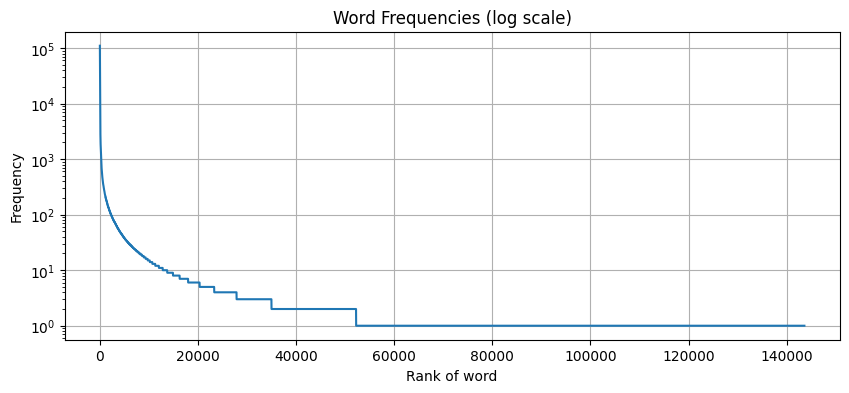

In [17]:
# this is from the previous lab :

vocab,word_counts = vocabulary(ng_train_text)
counts = list(word_counts.values())
counts.sort(reverse=True)

plt.figure(figsize=(10, 4))
plt.plot(counts)
plt.yscale('log')
plt.title("Word Frequencies (log scale)")
plt.xlabel("Rank of word")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [18]:

k = 15000  # for example
top_k_total = sum(counts[:k])
full_total = sum(counts)
coverage = top_k_total / full_total

print(f'Coverage by top {k} words: {coverage:.2%}')


Coverage by top 15000 words: 92.92%


* we can conclude that a vocabulary size of 15000 is enough scince it covers around  93% of the tokens in the dataset.
* and it's clearly shown by the tail of the distribution that there exist typos or noise , words that appear once and not meaningful, so we can keep only frequent words.
* as further pre_processing we can add:   
  * remove stopwords (they don't usully add meaning),
  * apply stemming ,
  * remove numbers, because generally they don't add meaning,
  * remove punctuation
  * remove word with no meaning (around 1-2 char)
  * HTML TAGS also should be removed
  *Set a minimum frequency threshold to remove rare words that appear too infrequently.


In [19]:
list(vocab)[100000:100005]

['2-v-', '.wht', 'bfp', 'qu+7', '=m/5']

In [20]:
import re
from nltk.stem import SnowballStemmer

# Initialize the stemmer
stemmer = SnowballStemmer("english")

# Define cleaning patterns
REMOVE_NUMBERS = re.compile(r"[0-9]+")
REMOVE_PUNCT = re.compile(r"[.;:!\'?,\"()\[\]]")
REMOVE_SHORT = re.compile(r"\b\w{1,2}\b")
REPLACE_HTML = re.compile(r"(<br\s*/><br\s*/>)|(\-)|(\/)")

# General cleaning function
def clean_documents(docs, labels=None, apply_stemming=True):
    cleaned_docs = []
    cleaned_labels = [] if labels else None

    for i, doc in enumerate(docs):
        clean_doc = []
        for token in doc:
            token = token.lower()
            token = REMOVE_NUMBERS.sub("", token)
            token = REMOVE_PUNCT.sub("", token)
            token = REPLACE_HTML.sub(" ", token)
            if token and not REMOVE_SHORT.fullmatch(token) and token.isalpha():
                if apply_stemming:
                    token = stemmer.stem(token)
                clean_doc.append(token)
        if clean_doc:
            cleaned_docs.append(clean_doc)
            if labels:
                cleaned_labels.append(labels[i])

    return (cleaned_docs, cleaned_labels) if labels else cleaned_docs

In [21]:
ng_train_text_clean, ng_train_labels_clean = clean_documents(ng_train_text, ng_train_labels, apply_stemming=True)
ng_test_text_clean = clean_documents(ng_test_text, apply_stemming=True)

Before creating the vocabulary, put aside some training data for a **validation set** !

In [22]:
from sklearn.model_selection import train_test_split
train_texts_split, val_texts, train_labels_split, val_labels = train_test_split(ng_train_text_clean, ng_train_labels_clean, test_size=0.2, random_state=42)


In [23]:
# Get the vocabulary from 'train_texts_splt'
vocab, word_counts = vocabulary(train_texts_split, voc_threshold=20000, min_count=4)


In [24]:
train_texts_split

[['the',
  'word',
  'doktor',
  'kultur',
  'the',
  'ottawa',
  'citizen',
  'rememb',
  'unhook',
  'the',
  'nitrous',
  'oxid',
  'befor',
  'you',
  'leav',
  'the',
  'dentist',
  'chair'],
 ['and',
  'with',
  'the',
  'big',
  'degre',
  'got',
  'imagin',
  'huh',
  'the',
  'alleg',
  'dichotomi',
  'between',
  'imagin',
  'and',
  'knowledg',
  'one',
  'the',
  'most',
  'pernici',
  'fallaci',
  'the',
  'new',
  'age',
  'michael',
  'thank',
  'for',
  'the',
  'generous',
  'offer',
  'but',
  'have',
  'quit',
  'enough',
  'dream',
  'our',
  'own',
  'thank',
  'you',
  'you',
  'the',
  'other',
  'hand',
  'are',
  'let',
  'your',
  'own',
  'dream',
  'wast',
  'fail',
  'get',
  'the',
  'your',
  'choic',
  'here',
  'which',
  'would',
  'give',
  'your',
  'imagin',
  'wing',
  'just',
  'show',
  'this',
  'flame',
  'leav',
  'you',
  'with',
  'quot',
  'from',
  'the',
  'bodi',
  'becom',
  'one',
  'not',
  'bad',
  'you',
  'know'],
 ['how',
  'about

In [25]:
len(vocab)

13356

In [26]:
vocab

{'the': 1,
 'and': 2,
 'that': 3,
 'for': 4,
 'you': 5,
 'this': 6,
 'have': 7,
 'not': 8,
 'are': 9,
 'with': 10,
 'but': 11,
 'was': 12,
 'they': 13,
 'from': 14,
 'can': 15,
 'will': 16,
 'use': 17,
 'would': 18,
 'one': 19,
 'there': 20,
 'what': 21,
 'all': 22,
 'about': 23,
 'has': 24,
 'your': 25,
 'some': 26,
 'ani': 27,
 'other': 28,
 'which': 29,
 'who': 30,
 'max': 31,
 'like': 32,
 'get': 33,
 'out': 34,
 'peopl': 35,
 'their': 36,
 'more': 37,
 'were': 38,
 'doe': 39,
 'when': 40,
 'know': 41,
 'just': 42,
 'onli': 43,
 'time': 44,
 'also': 45,
 'how': 46,
 'them': 47,
 'had': 48,
 'been': 49,
 'his': 50,
 'think': 51,
 'than': 52,
 'make': 53,
 'say': 54,
 'work': 55,
 'could': 56,
 'then': 57,
 'file': 58,
 'should': 59,
 'these': 60,
 'did': 61,
 'new': 62,
 'year': 63,
 'system': 64,
 'good': 65,
 'becaus': 66,
 'may': 67,
 'want': 68,
 'even': 69,
 'problem': 70,
 'veri': 71,
 'well': 72,
 'see': 73,
 'right': 74,
 'need': 75,
 'into': 76,
 'thing': 77,
 'way': 78,
 '

### I.3 - Symbolic text representations

We can use the ```CountVectorizer``` class from scikit-learn to obtain the first set of representations:
- Use the appropriate argument to get your own vocabulary
- Fit the vectorizer on your training data, transform your test data
- Create a ```LogisticRegression``` model and train it with these representations. Display the confusion matrix using functions from ```sklearn.metrics```

Then, re-execute the same pipeline with the ```TfidfVectorizer```.

<div class='alert alert-block alert-info'>
            Code:</div>

In [27]:
# count vectorize need doc not seperat tokens
train_texts_joined = [" ".join(doc) for doc in train_texts_split]
val_texts_joined = [" ".join(doc) for doc in val_texts]

              precision    recall  f1-score   support

           0       0.83      0.87      0.85       570
           1       0.80      0.87      0.83       482
           2       0.75      0.74      0.74       455
           3       0.80      0.70      0.75       105
           4       0.77      0.73      0.75       299
           5       0.86      0.76      0.81       290

    accuracy                           0.80      2201
   macro avg       0.80      0.78      0.79      2201
weighted avg       0.80      0.80      0.80      2201



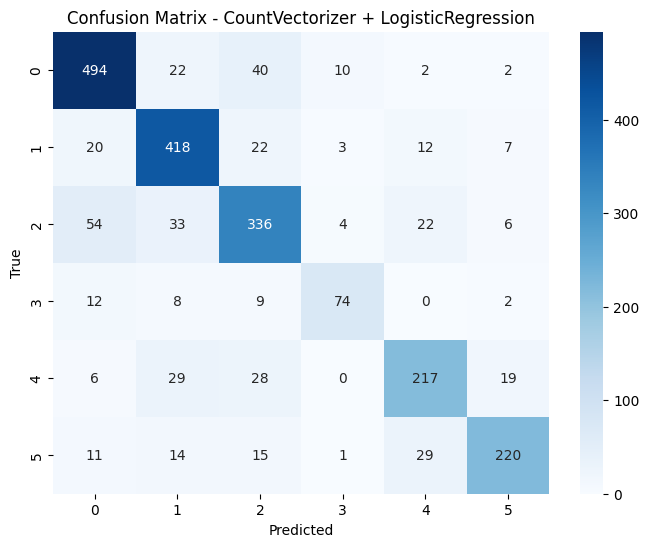

In [28]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix ,accuracy_score ,ConfusionMatrixDisplay

vocab_fixed = {word: i for i, word in enumerate(vocab.keys())}


# Vectorize make a BOW :
vectorizer = CountVectorizer(vocabulary = vocab_fixed) ## use my vocab
X_train = vectorizer.transform(train_texts_joined) ## don't use fit, i have already my vocab
X_val = vectorizer.transform(val_texts_joined)

# Train model
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, train_labels_split)

# Predict
y_pred = clf.predict(X_val)

# Evaluate
print(classification_report(val_labels, y_pred))
cm = confusion_matrix(val_labels, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - CountVectorizer + LogisticRegression")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


Test Set Performance:

              precision    recall  f1-score   support

           0       0.76      0.71      0.73      1911
           1       0.57      0.86      0.69      1534
           2       0.69      0.48      0.56      1523
           3       0.79      0.50      0.61       382
           4       0.57      0.67      0.61      1027
           5       0.78      0.61      0.69       940

    accuracy                           0.66      7317
   macro avg       0.69      0.64      0.65      7317
weighted avg       0.68      0.66      0.66      7317



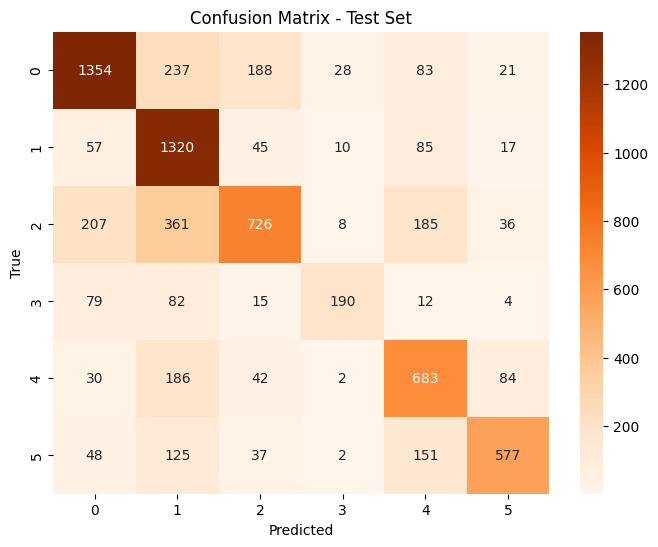

In [30]:
test_texts_joined = [" ".join(doc) for doc in ng_test_text]
X_test = vectorizer.transform(test_texts_joined)


y_test_pred = clf.predict(X_test)

print("Test Set Performance:\n")
print(classification_report(ng_test_labels, y_test_pred))
cm_test = confusion_matrix(ng_test_labels, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Oranges')
plt.title("Confusion Matrix - Test Set")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [ ]:
# TF-IDF = Term Frequency – Inverse Document Frequency
# -----------------------------------------------
# - Term Frequency (TF): how often a word appears in a document
#   relative to the total number of words in that document.
#   TF(word, doc) = count(word in doc) / total words in doc
#
# - Inverse Document Frequency (IDF): measures how "informative" a word is
#   across the entire corpus. Words that appear in many documents get
#   lower weight, while rare words get higher weight.
#   IDF(word) = log( (1 + N) / (1 + df(word)) ) + 1
#   where N = total number of documents,
#         df(word) = number of documents containing the word
#
# - TF-IDF score = TF * IDF
#   → High when a word is frequent in one document but rare across the corpus
#   → Low for common words (e.g. "the", "and") that appear everywhere
#
# In practice:
# - .fit() on training data = computes IDF values from the corpus
# - .transform() = applies TF * IDF weighting to documents


              precision    recall  f1-score   support

           0       0.85      0.91      0.88       570
           1       0.84      0.89      0.87       482
           2       0.78      0.81      0.79       455
           3       0.95      0.59      0.73       105
           4       0.82      0.81      0.81       299
           5       0.90      0.78      0.84       290

    accuracy                           0.84      2201
   macro avg       0.86      0.80      0.82      2201
weighted avg       0.84      0.84      0.84      2201



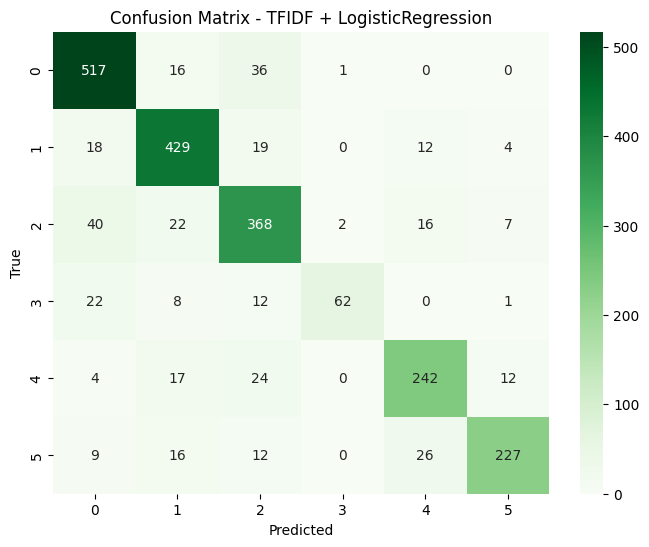

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Vectorize using TF-IDF
tfidf = TfidfVectorizer(vocabulary = vocab_fixed)
X_train_tfidf = tfidf.fit_transform(train_texts_joined) # still need to fit to learn the idf
X_val_tfidf = tfidf.transform(val_texts_joined)

# Train model
clf_tfidf = LogisticRegression(max_iter=1000)
clf_tfidf.fit(X_train_tfidf, train_labels_split)

# Predict and evaluate
y_pred_tfidf = clf_tfidf.predict(X_val_tfidf)

print(classification_report(val_labels, y_pred_tfidf))
cm_tfidf = confusion_matrix(val_labels, y_pred_tfidf)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_tfidf, annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix - TFIDF + LogisticRegression")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


Test Set Performance:

              precision    recall  f1-score   support

           0       0.79      0.80      0.79      1911
           1       0.62      0.89      0.73      1534
           2       0.72      0.63      0.67      1523
           3       0.89      0.41      0.57       382
           4       0.72      0.68      0.70      1027
           5       0.84      0.65      0.73       940

    accuracy                           0.72      7317
   macro avg       0.76      0.67      0.70      7317
weighted avg       0.74      0.72      0.72      7317



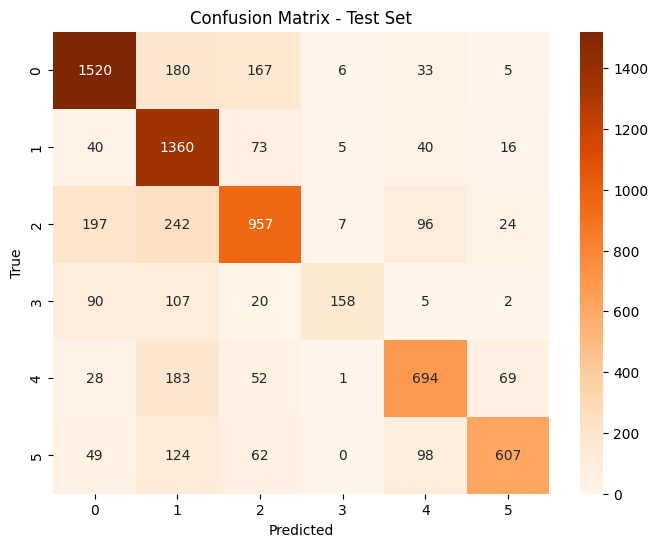

In [54]:
test_texts_joined = [" ".join(doc) for doc in ng_test_text]
X_test = tfidf.transform(test_texts_joined)


y_test_pred = clf_tfidf.predict(X_test)

print("Test Set Performance:\n")
print(classification_report(ng_test_labels, y_test_pred))
cm_test = confusion_matrix(ng_test_labels, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Oranges')
plt.title("Confusion Matrix - Test Set")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


we can see that the accuray has been increased, this is

### I.4 - Dense Representations from Topic Modeling

Now, the goal is to re-use the bag-of-words representations we obtained earlier - but reduce their dimension through a **topic model**. Note that this allows to obtain reduced **document representations**, which we can again use directly to perform classification.
- Do this with two models: ```TruncatedSVD``` and ```LatentDirichletAllocation```
- Pick $300$ as the dimensionality of the latent representation (*i.e*, the number of topics)

<div class='alert alert-block alert-info'>
            Code:</div>

In [ ]:
from sklearn.decomposition import TruncatedSVD

# Reduce to 300 dimensions
svd = TruncatedSVD(n_components=300, random_state=42)
X_train_svd = svd.fit_transform(X_train)
X_val_svd = svd.transform(X_val)


In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=300, random_state=42)
X_train_lda = lda.fit_transform(X_train)
X_val_lda = lda.transform(X_val)


In [ ]:
# With SVD
clf_svd = LogisticRegression(max_iter=1000)
clf_svd.fit(X_train_svd, train_labels_split)
y_pred_svd = clf_svd.predict(X_val_svd)
print("SVD-based Classification:")
print(classification_report(val_labels, y_pred_svd))

# With LDA
clf_lda = LogisticRegression(max_iter=1000)
clf_lda.fit(X_train_lda, train_labels_split)
y_pred_lda = clf_lda.predict(X_val_lda)
print("LDA-based Classification:")
print(classification_report(val_labels, y_pred_lda))


SVD-based Classification:
              precision    recall  f1-score   support

           0       0.82      0.85      0.84       570
           1       0.77      0.82      0.80       482
           2       0.72      0.71      0.72       455
           3       0.77      0.68      0.72       105
           4       0.74      0.69      0.71       299
           5       0.80      0.73      0.76       290

    accuracy                           0.77      2201
   macro avg       0.77      0.75      0.76      2201
weighted avg       0.77      0.77      0.77      2201

LDA-based Classification:
              precision    recall  f1-score   support

           0       0.76      0.86      0.81       570
           1       0.74      0.76      0.75       482
           2       0.64      0.65      0.64       455
           3       0.93      0.40      0.56       105
           4       0.74      0.66      0.70       299
           5       0.76      0.74      0.75       290

    accuracy             

### I.5 - Dense Count-based Representations

The following function allows to obtain very large-dimensional vectors for **words**. We will now follow a different procedure:
- Use ```TruncatedSVD```to obtain **word embeddings** of dimension $300$ from the output of the ```co_occurence_matrix```function, to which you can apply any intermediate transformation you see fit.
- Complete the following ```sentence_representations``` matrix, which will allow you to obtain **document representations** from **word embeddings**.
- Put the pipeline together and obtain document representations for both training and testing data, using word embeddings you got from the *training data co-occurence matrix*.
- Apply the same classification model as before, and display the results.

<div class='alert alert-block alert-info'>
            Code:</div>

In [55]:
def co_occurence_matrix(corpus, vocabulary, window=0, distance_weighting=False):
    """
    Params:
        corpus (list of list of strings): corpus of sentences
        vocabulary (dictionary): words to use in the matrix
            -> Must map each word to a unique integer index (0 ... len(vocabulary)-1)
        window (int): size of the context window; when 0, the context is the whole sentence
        distance_weighting (bool): indicates if we use a weight depending on the distance between words for co-oc counts
    Returns:
        matrix (array of size (len(vocabulary), len(vocabulary))):
            the co-oc matrix, using the same ordering as the vocabulary given in input
    """
    l = len(vocabulary)
    M = np.zeros((l, l))

    for sent in corpus:
        # Keep only words that exist in the vocabulary
        sent = [w for w in sent if w in vocabulary]

        # Obtain the indexes of the words in the sentence from the vocabulary
        sent_idx = [vocabulary[w] for w in sent]

        # Avoid one-word sentences - can create issues in normalization
        if len(sent_idx) == 1:
            sent_idx.append(l - 1)   # append last valid index (safe)

        # Go through the indexes and add 1 / dist(i,j) to M[i,j] if words of index i and j appear in the same window
        for i, idx in enumerate(sent_idx):
            # Safety: ignore any index that is out of bounds (shouldn’t happen if vocab is correct)
            if idx >= l:
                continue

            # If we consider a limited context:
            if window > 0:
                # Create a list containing the indexes that are on the left of the current index 'idx_i'
                l_ctx_idx = sent_idx[max(0, i - window):i]
            else:
                # If the context is the entire document:
                l_ctx_idx = sent_idx[:i]

            # Go through the list and update M[i,j]
            for j, ctx_idx in enumerate(l_ctx_idx):
                if ctx_idx >= l:
                    continue  # skip invalid indices

                if distance_weighting:
                    # Weight inversely proportional to distance between words
                    dist = i - (i - len(l_ctx_idx) + j)
                    weight = 1.0 / (dist + 1e-5)
                else:
                    weight = 1.0

                M[idx, ctx_idx] += weight
                M[ctx_idx, idx] += weight  # symmetry

    return M


In [56]:
# Obtain the co-occurence matrix, transform it as needed, reduce its dimension

M = co_occurence_matrix(train_texts_split, vocab, window=4, distance_weighting=True)


In [ ]:
svd = TruncatedSVD(n_components=300, random_state=42)
word_embeddings = svd.fit_transform(M)

We will now use these representations for classification.
The basic model will be constructed in two steps:
- A function to obtain vector representations of criticism, from text, vocabulary, and vector representations of words. Such a function (to be completed below) will associate to each word of a review its embeddings, and create the representation for the whole sentence by summing these embeddings.
- A classifier will take these representations as input and make a prediction. To achieve this, we can first use logistic regression ```LogisticRegression``` from ```scikit-learn```

<div class='alert alert-block alert-info'>
            Code:</div>

In [43]:
def sentence_representations(texts, vocabulary, embeddings, np_func=np.mean):
    """
    Represent the sentences as a combination of the vector of its words.
    Parameters
    ----------
    texts : a list of sentences
    vocabulary : dict
        From words to indexes of vector.
    embeddings : Matrix containing word representations
    np_func : function (default: np.sum)
        A numpy matrix operation that can be applied columnwise,
        like `np.mean`, `np.sum`, or `np.prod`.
    Returns
    -------
    np.array, dimension `(len(texts), embeddings.shape[1])`
    """
    reps = []
    for sent in texts:
        word_vecs = []
        for word in sent:
            idx = vocabulary.get(word, None)
            if idx is not None and idx < len(embeddings):
                word_vecs.append(embeddings[idx])
        if word_vecs:  #  only compute if there are valid vectors
            sent_vec = np_func(word_vecs, axis=0)
        else:
            sent_vec = np.zeros(embeddings.shape[1])  # fallback: zero vector
        reps.append(sent_vec)
    return np.array(reps)


In [44]:
# Obtain document representations, apply the classifier
X_train_embed = sentence_representations(train_texts_split, vocab, word_embeddings, np_func=np.mean)
X_val_embed = sentence_representations(val_texts, vocab, word_embeddings, np_func=np.mean)


NameError: name 'word_embeddings' is not defined

Document classification using dense word embeddings (co-occurrence + SVD):
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       570
           1       0.84      0.83      0.84       482
           2       0.75      0.76      0.75       455
           3       0.74      0.64      0.68       105
           4       0.71      0.75      0.73       299
           5       0.78      0.79      0.79       290

    accuracy                           0.80      2201
   macro avg       0.78      0.77      0.78      2201
weighted avg       0.80      0.80      0.80      2201

Accuracy: 0.8028


Text(0.5, 1.0, 'Confusion Matrix - Co-oc SVD + LogisticRegression')

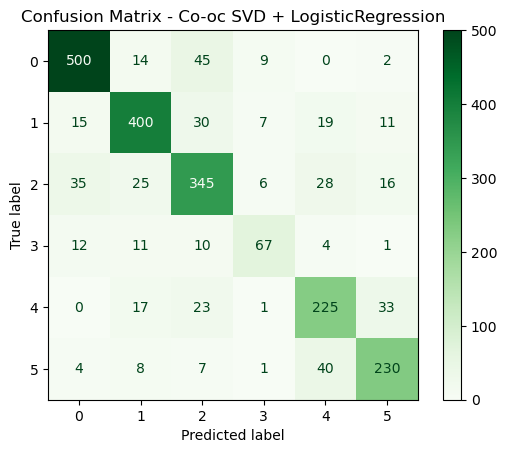

In [ ]:
clf_embed = LogisticRegression(max_iter=1000)
clf_embed.fit(X_train_embed, train_labels_split)

y_pred_embed = clf_embed.predict(X_val_embed)

print("Document classification using dense word embeddings (co-occurrence + SVD):")
print(classification_report(val_labels, y_pred_embed))

# Accuracy
acc_embed = accuracy_score(val_labels, y_pred_embed)
print("Accuracy:", round(acc_embed, 4))

# Confusion matrix
cm = confusion_matrix(val_labels, y_pred_embed)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Greens")
disp.ax_.set_title("Confusion Matrix - Co-oc SVD + LogisticRegression")

### I.6 - Dense Prediction-based Representations

We will now use two types of word embeddings:
1. From ```Word2Vec```: which we will train ourselves
2. From ```GloVe```: which we will import

We will use the ```gensim``` library for its implementation of word2vec in python. Since we want to keep the same vocabulary as before: we'll first create the class, then get the vocabulary we generated above.

#### Glove

In [32]:
# pip install gensim

In [31]:
import gensim.downloader as api
loaded_glove_model = api.load("glove-wiki-gigaword-300")

[==================================================] 100.0% 376.1/376.1MB downloaded


We can extract the embedding matrix this way, and check its size:

In [33]:
loaded_glove_embeddings = loaded_glove_model.vectors
print(loaded_glove_embeddings.shape)

(400000, 300)


We can see that there are $400,000$ words represented, and that the embeddings are of size $300$. We define a function that returns, from the loaded model, the vocabulary and the embedding matrix according to the structures we used before. We add, here again, an unknown word "UNK" in case there are words in our data that are not part of the $400,000$ words represented here.

In [34]:
def get_glove_voc_and_embeddings(glove_model):
    voc = {word : index for index, word in enumerate(glove_model.index_to_key)}
    voc['UNK'] = len(voc)
    embeddings = glove_model.vectors
    return voc, embeddings

In [35]:
loaded_glove_voc, loaded_glove_embeddings = get_glove_voc_and_embeddings(loaded_glove_model)

To be able to merge these $400.000$ words with those that are in our vocabulary, we can create a specific function that will extract the representations of the words that are in our vocabulary and return a matrix of the appropriate size:

In [36]:
def get_glove_adapted_embeddings(glove_model, input_voc):
    keys = {i: glove_model.key_to_index.get(w, None) for w, i in input_voc.items()}
    index_dict = {i: key for i, key in keys.items() if key is not None}
    embeddings = np.zeros((len(input_voc),glove_model.vectors.shape[1]))
    for i, ind in index_dict.items():
        embeddings[i] = glove_model.vectors[ind]
    return embeddings

This function takes as input the model loaded using the Gensim API, as well as a vocabulary we created ourselves, and returns the embedding matrix from the loaded model, for the words in our vocabulary and in the right order.


In [39]:
GloveEmbeddings = get_glove_adapted_embeddings(loaded_glove_model, vocab_fixed) # Use your vocabulary

In [40]:
print(GloveEmbeddings.shape)

(13356, 300)


In [41]:
glove_zeros = np.sum(np.all(GloveEmbeddings == 0, axis=1))
print(f"Zero vectors in GloVe: {glove_zeros} / {GloveEmbeddings.shape[0]}")

Zero vectors in GloVe: 4414 / 13356


Classification report (GloVe):
              precision    recall  f1-score   support

           0       0.81      0.85      0.83       570
           1       0.86      0.83      0.85       482
           2       0.71      0.75      0.73       455
           3       0.78      0.51      0.62       105
           4       0.67      0.73      0.70       299
           5       0.83      0.76      0.79       290

    accuracy                           0.78      2201
   macro avg       0.78      0.74      0.75      2201
weighted avg       0.78      0.78      0.78      2201

Accuracy: 0.781


Text(0.5, 1.0, 'Confusion Matrix - GloVe + LogisticRegression')

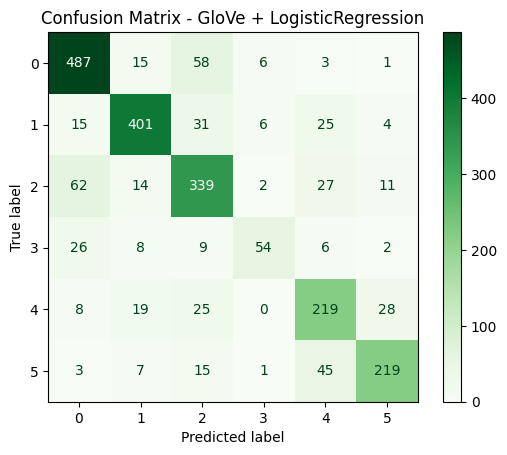

In [46]:
# Create sentence representations
X_train_glove = sentence_representations(train_texts_split, vocab_fixed, GloveEmbeddings, np_func=np.mean)
X_val_glove = sentence_representations(val_texts, vocab_fixed, GloveEmbeddings, np_func=np.mean)

# Train and evaluate
clf_glove = LogisticRegression(max_iter=1000)
clf_glove.fit(X_train_glove, train_labels_split)
y_pred_glove = clf_glove.predict(X_val_glove)

print("Classification report (GloVe):")
print(classification_report(val_labels, y_pred_glove))
print("Accuracy:", round(accuracy_score(val_labels, y_pred_glove), 4))

cm = confusion_matrix(val_labels, y_pred_glove)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Greens")
disp.ax_.set_title("Confusion Matrix - GloVe + LogisticRegression")

#### Word2Vec

We will use the ```gensim``` library for its implementation of word2vec in python. We'll have to make a specific use of it, since we want to keep the same vocabulary as before: we'll first create the class, then get the vocabulary we generated above.

In [48]:
from gensim.models import Word2Vec

model = Word2Vec(vector_size=300,
                 window=5,
                 #null_word=len(word_counts) -1, # Use word counts
                 epochs=30)
model.build_vocab_from_freq(word_counts) # Use word counts

The model takes as input a **list of list of words**: you need to tokenize the data beforehand.
In this case, you also need to indicate to the model the number of examples it should train with.
<div class='alert alert-block alert-info'>
            Code:</div>

In [51]:
ng_train_text_tokenized = []
ex = 0
for sent in train_texts_split:
    ng_train_text_tokenized.append(sent)
    ex += 1

In [52]:
model.train(ng_train_text_tokenized, total_examples=ex, epochs=30, report_delay=1)

(28354624, 35847750)

In [53]:
W2VEmbeddings = model.wv.vectors
print(W2VEmbeddings.shape)

(11355, 300)


In [54]:
def get_w2v_adapted_embeddings(w2v_model, vocab, dim=300):
    embedding_matrix = np.zeros((len(vocab), dim))
    for word, idx in vocab.items():
        if word in w2v_model:
            embedding_matrix[idx] = w2v_model[word]
    return embedding_matrix

W2VEmbeddings = get_w2v_adapted_embeddings(model.wv, vocab_fixed)


Classification report (Word2Vec document embeddings):
              precision    recall  f1-score   support

           0       0.88      0.89      0.88       570
           1       0.83      0.82      0.82       482
           2       0.74      0.77      0.75       455
           3       0.78      0.62      0.69       105
           4       0.71      0.74      0.72       299
           5       0.81      0.80      0.81       290

    accuracy                           0.80      2201
   macro avg       0.79      0.77      0.78      2201
weighted avg       0.80      0.80      0.80      2201

Accuracy: 0.8024


Text(0.5, 1.0, 'Confusion Matrix - Word2Vec + LogisticRegression')

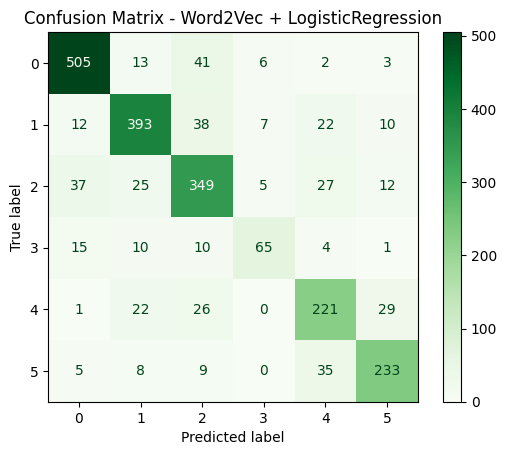

In [56]:
X_train_embed = sentence_representations(train_texts_split, vocab_fixed, W2VEmbeddings)
X_val_embed = sentence_representations(val_texts, vocab_fixed, W2VEmbeddings)


clf_embed = LogisticRegression(max_iter=1000)
clf_embed.fit(X_train_embed, train_labels_split)

y_pred_embed = clf_embed.predict(X_val_embed)

print("Classification report (Word2Vec document embeddings):")
print(classification_report(val_labels, y_pred_embed))

# Accuracy
acc_embed = accuracy_score(val_labels, y_pred_embed)
print("Accuracy:", round(acc_embed, 4))

# Confusion matrix
cm = confusion_matrix(val_labels, y_pred_embed)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Greens")
disp.ax_.set_title("Confusion Matrix - Word2Vec + LogisticRegression")

In [57]:
print(len(vocab))
print(W2VEmbeddings.shape)
print(GloveEmbeddings.shape)


13356
(13356, 300)
(13356, 300)


<div class='alert alert-block alert-warning'>
            Question:</div>

- Why can we expect that the results obtained with embeddings extracted from representations pre-trained with Gl0ve are much better than word2vec ? What would be a 'fair' way to compare Gl0ve with word2vec ?

Glove embeddings are pre-trained on very large corpora. however our word2vec model was trained on a much smaller dataset, so its reprisentations are much more limited.
in my model the glove gives slight worst accuraccy likely due to the fact that 30% of our vocab is unkown to glove leading to zero vectors to those token. maybe because of stemming wich gives words like 'bett' , 'runn' wich have no meaning and glove had been trained on real words (i don't know if this is true).
##### my idea is glove still achieves nearly the same accuracy as our word2vec even thought it's using onlyu 60% of the vocabulary, thi highlightss the strenght of pre-trained embeddings wich generalize well

a fair way to compare glove and w2vec is to control the vocabulary size, embedding dimention and use the same the same model to test. we can also use the same classifer training / validation split , and document representaion function (sum or averag embedding).
* to go further we could compare it to a pre-trained Word2Vec model trained on large corpora,

<div class='alert alert-block alert-warning'>
            Question:</div>

- Try to have an high-level analysis of the results. Which representation works the best ? Did the confusion matrix give you any insight ?

word2vec words slightly better thatn glove in my case (we have gived a justification in the previous question).
* the confusion matricies show that w2vec is better at distinguishing between classe especially class 0 with 499 correct and only 14 wrong. while glove struggle more with some classes (class 3  0.51 recall ).both models struggle with classes lik 2 and 4 but still w2vec performs slightly better (36 FP agains 52 FP to glove) wich demonstrates better overall acuracy.


# II - Text classification with Pytorch

The goal of this second part of the lab is double: an introduction to using Pytorch for treating textual data, and implementing neural classification models that we can apply to our data - and then compare it to the models implemented previously.

In [58]:
import torch
import torch.nn as nn

### II.1 A (very small) introduction to pytorch

Pytorch Tensors are very similar to Numpy arrays, with the added benefit of being usable on GPU. For a short tutorial on various methods to create tensors of particular types, see [this link](https://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html#sphx-glr-beginner-blitz-tensor-tutorial-py).
The important things to note are that Tensors can be created empty, from lists, and it is very easy to convert a numpy array into a pytorch tensor, and inversely.

In [ ]:
a = torch.LongTensor(5)
b = torch.LongTensor([5])

print(a)
print(b)

tensor([0, 0, 0, 0, 0])
tensor([5])


In [ ]:
a = torch.FloatTensor([2])
b = torch.FloatTensor([3])

print(a + b)

tensor([5.])


The main interest in us using Pytorch is the ```autograd``` package. ```torch.Tensor```objects have an attribute ```.requires_grad```; if set as True, it starts to track all operations on it. When you finish your computation, can call ```.backward()``` and all the gradients are computed automatically (and stored in the ```.grad``` attribute).

One way to easily cut a tensor from the computational once it is not needed anymore is to use ```.detach()```.
More info on automatic differentiation in pytorch on [this link](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html#sphx-glr-beginner-blitz-autograd-tutorial-py).

In [ ]:
x = torch.tensor(1., requires_grad=True)
w = torch.tensor(2., requires_grad=True)
b = torch.tensor(3., requires_grad=True)

# Build a computational graph.
y = w * x + b    # y = 2 * x + 3

# Compute gradients.
y.backward()

# Print out the gradients.
print(x.grad)    # x.grad = 2
print(w.grad)    # w.grad = 1
print(b.grad)    # b.grad = 1

tensor(2.)
tensor(1.)
tensor(1.)


In [ ]:
x = torch.randn(10, 3)
y = torch.randn(10, 2)

# Build a fully connected layer.
linear = nn.Linear(3, 2)
for name, p in linear.named_parameters():
    print(name)
    print(p)

# Build loss function - Mean Square Error
criterion = nn.MSELoss()

# Forward pass.
pred = linear(x)

# Compute loss.
loss = criterion(pred, y)
print('Initial loss: ', loss.item())

# Backward pass.
loss.backward()

# Print out the gradients.
print ('dL/dw: ', linear.weight.grad)
print ('dL/db: ', linear.bias.grad)

weight
Parameter containing:
tensor([[ 0.3066, -0.1833,  0.5283],
        [ 0.2738,  0.4272, -0.5075]], requires_grad=True)
bias
Parameter containing:
tensor([-0.3855, -0.1448], requires_grad=True)
Initial loss:  2.4248366355895996
dL/dw:  tensor([[ 0.5204, -0.1604,  0.3477],
        [-0.7031,  0.8097, -0.5750]])
dL/db:  tensor([-0.0375,  0.7287])


In [ ]:
# You can perform gradient descent manually, with an in-place update ...
linear.weight.data.sub_(0.01 * linear.weight.grad.data)
linear.bias.data.sub_(0.01 * linear.bias.grad.data)

# Print out the loss after 1-step gradient descent.
pred = linear(x)
loss = criterion(pred, y)
print('Loss after one update: ', loss.item())

Loss after one update:  2.400742292404175


In [ ]:
# Use the optim package to define an Optimizer that will update the weights of the model.
optimizer = torch.optim.SGD(linear.parameters(), lr=0.01)

# By default, gradients are accumulated in buffers( i.e, not overwritten) whenever .backward()
# is called. Before the backward pass, we need to use the optimizer object to zero all of the
# gradients.
optimizer.zero_grad()
loss.backward()

# Calling the step function on an Optimizer makes an update to its parameters
optimizer.step()

# Print out the loss after the second step of gradient descent.
pred = linear(x)
loss = criterion(pred, y)
print('Loss after two updates: ', loss.item())

Loss after two updates:  2.3774731159210205


### II.2 Tools for data processing

```torch.utils.data.Dataset``` is an abstract class representing a dataset. Your custom dataset should inherit ```Dataset``` and override the following methods:
- ```__len__``` so that ```len(dataset)``` returns the size of the dataset.
- ```__getitem__``` to support the indexing such that ```dataset[i]``` can be used to get the i-th sample

Here is a toy example:

In [60]:
toy_corpus = ['I walked down down the boulevard',
              'I walked down the avenue',
              'I ran down the boulevard',
              'I walk down the city',
              'I walk down the the avenue']

toy_categories = [0, 0, 1, 0, 0]

In [59]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    # A pytorch dataset class for holding data for a text classification task.
    def __init__(self, data, categories):
        # Upon creating the Dataset object, store the data in an attribute
        # Split the text data and labels from each other
        self.X, self.Y = [], []
        for x, y in zip(data, categories):
            # We will propably need to preprocess the data - have it done in a separate method
            # We do it here because we might need corpus-wide info to do the preprocessing
            # For example, cutting all examples to the same length
            self.X.append(self.preprocess(x))
            self.Y.append(y)

    # Method allowing you to preprocess data
    def preprocess(self, text):
        text_pp = text.lower().strip()
        return text_pp

    # Overriding the method __len__ so that len(CustomDatasetName) returns the number of data samples
    def __len__(self):
        return len(self.Y)

    # Overriding the method __getitem__ so that CustomDatasetName[i] returns the i-th sample of the dataset
    def __getitem__(self, idx):
           return self.X[idx], self.Y[idx]

In [61]:
toy_dataset = CustomDataset(toy_corpus, toy_categories)

In [62]:
print(len(toy_dataset))
for i in range(len(toy_dataset)):
    print(toy_dataset[i])

5
('i walked down down the boulevard', 0)
('i walked down the avenue', 0)
('i ran down the boulevard', 1)
('i walk down the city', 0)
('i walk down the the avenue', 0)


```torch.utils.data.DataLoader``` is what we call an iterator, which provides very useful features:
- Batching the data
- Shuffling the data
- Load the data in parallel using multiprocessing workers.
and can be created very simply from a ```Dataset```. Continuing on our simple example:

In [63]:
toy_dataloader = DataLoader(toy_dataset, batch_size = 2, shuffle = True)

In [64]:
for e in range(3):
    print("Epoch:" + str(e))
    for x, y in toy_dataloader:
        print("Batch: " + str(x) + "; labels: " + str(y))

Epoch:0
Batch: ('i walk down the city', 'i walked down the avenue'); labels: tensor([0, 0])
Batch: ('i ran down the boulevard', 'i walked down down the boulevard'); labels: tensor([1, 0])
Batch: ('i walk down the the avenue',); labels: tensor([0])
Epoch:1
Batch: ('i ran down the boulevard', 'i walked down the avenue'); labels: tensor([1, 0])
Batch: ('i walked down down the boulevard', 'i walk down the the avenue'); labels: tensor([0, 0])
Batch: ('i walk down the city',); labels: tensor([0])
Epoch:2
Batch: ('i walk down the the avenue', 'i walked down down the boulevard'); labels: tensor([0, 0])
Batch: ('i walked down the avenue', 'i ran down the boulevard'); labels: tensor([0, 1])
Batch: ('i walk down the city',); labels: tensor([0])


#### Data processing of a text dataset

Now, we would like to apply what we saw to our case, and **create a specific class** ```TextClassificationDataset``` **inheriting** ```Dataset``` that will:
- Create a vocabulary from the data (same as above)
- Preprocess the data using this vocabulary, adding whatever we need for our pytorch model
- Have a ```__getitem__``` method that allows us to use the class with a ```Dataloader``` to easily build batches.

In [65]:
from torch.nn import functional as F
import random

from torch.nn.utils.rnn import pad_sequence

We will now need to create a ```TextClassificationDataset``` and a ```Dataloader``` for the training data, the validation data, and the testing data.

We will implement our ```TextClassificationDataset``` class, that we will build from:
- A list of documents: ```data```
- A list of the corresponding categories: ```categories```
We will add three optional arguments:
- First, a way to input a vocabulary (so that we can re-use the training vocabulary on the validation and training ```TextClassificationDataset```). By default, the value of the argument is ```None```.
- In order to work with batches, we will need to have sequences of the same size. That can be done via **padding** but we will still need to limit the size of documents (to avoid having batches of huge sequences that are mostly empty because of one very long documents) to a ```max_length```. Let's put it to 100 by default.
- Lastly, a ```min_freq``` that indicates how many times a word must appear to be taken in the vocabulary.

The idea behind **padding** is to transform a list of pytorch tensors (of maybe different length) into a two dimensional tensor - which we can see as a batch. The size of the first dimension is the one of the longest tensor - and other are **padded** with a chosen symbol: here, we choose 0.

**Careful: the symbol 0 is then reserved for padding. That means the vocabulary must begin at 1 !**

In [ ]:
tensor_1 = torch.LongTensor([1, 4, 5])
tensor_2 = torch.LongTensor([2])
tensor_3 = torch.LongTensor([6, 7])

In [ ]:
tensor_padded = pad_sequence([tensor_1, tensor_2, tensor_3], batch_first=True, padding_value = 0)
print(tensor_padded)

tensor([[1, 4, 5],
        [2, 0, 0],
        [6, 7, 0]])


<div class='alert alert-block alert-info'>
            Code:</div>

In [ ]:
class TextClassificationDataset(Dataset):
    def __init__(self, data, categories, vocab = None, max_length = 200, voc_threshold = 10000):
        # Get all the data in a list
        self.data = data
        # Set the maximum length we will keep for the sequences
        self.max_length = max_length
        # Allow to import a vocabulary (for valid/test datasets, that will use the training vocabulary)
        if vocab is not None:
            self.word2idx, self.idx2word = vocab
        else:
            # If no vocabulary imported, build it (and reverse)
            self.word2idx, self.idx2word = self.build_vocab(self.data, voc_threshold)

        # We then need to tokenize the data ..
        tokenized_data =  self.data

        # Transform words into lists of indexes ... (use the .get() method to redirect unknown words to the UNK token)
        indexed_data = [
            [self.word2idx.get(word, self.word2idx["<UNK>"]) for word in doc]
            for doc in tokenized_data
        ]
        # And transform this list of lists into a list of Pytorch LongTensors
        tensor_data = [torch.LongTensor(doc[:self.max_length]) for doc in indexed_data]
        # And the categories into a FloatTensor
        tensor_y = torch.LongTensor(categories)
        # To finally cut it when it's above the maximum length
        cut_tensor_data = tensor_data

        # Now, we need to use the pad_sequence function to have the whole dataset represented as one tensor,
        # containing sequences of the same length. We choose the padding_value to be 0, the we want the
        # batch dimension to be the first dimension
        self.tensor_data = pad_sequence(cut_tensor_data, batch_first=True, padding_value=0)
        self.tensor_y = tensor_y

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # The iterator just gets one particular example with its category
        # The dataloader will take care of the shuffling and batching
        if torch.is_tensor(idx):
            idx = idx.tolist()
        return self.tensor_data[idx], self.tensor_y[idx]

    def build_vocab(self, corpus, voc_threshold):
        """
        Same as in the previously: we want to output word_index, a dictionary containing words
        and their corresponding indexes as {word : indexes}
        But we also want the reverse, which is a dictionary {indexes: word}
        """
        word_counts = {}
        for sentence in corpus:
            for word in sentence:
                word_counts[word] = word_counts.get(word, 0) + 1

        sorted_words = sorted([(w, c) for w, c in word_counts.items() if c >= voc_threshold],
                              key=lambda x: x[1], reverse=True)

        word2idx = {w: idx + 1 for idx, (w, _) in enumerate(sorted_words)}
        word2idx["<UNK>"] = len(word2idx) + 1

        idx2word = {idx: word for word, idx in word2idx.items()}

        return word2idx, idx2word

    def get_vocab(self):
        # A simple way to get the training vocab when building the valid/test
        return self.word2idx, self.idx2word

In [ ]:
training_dataset = TextClassificationDataset(train_texts_split, train_labels_split)
training_word2idx, training_idx2word = training_dataset.get_vocab()

In [ ]:
valid_dataset = TextClassificationDataset(val_texts, val_labels, (training_word2idx, training_idx2word))
test_dataset = TextClassificationDataset(ng_test_text, ng_test_labels, (training_word2idx, training_idx2word))

In [ ]:
training_dataloader = DataLoader(training_dataset, batch_size = 200, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size = 25)
test_dataloader = DataLoader(test_dataset, batch_size = 25)

In [ ]:
print(valid_dataset[1])

(tensor([10, 10,  6,  1, 10, 10, 10, 10, 10,  1, 10, 10, 10, 10, 10, 10, 10, 10,
        10,  5, 10,  1, 10, 10, 10,  2, 10, 10, 10, 10, 10, 10, 10, 10,  4,  1,
        10, 10,  1, 10,  6, 10, 10, 10,  1, 10, 10, 10, 10, 10,  8, 10, 10,  7,
        10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,  4,  1, 10, 10, 10, 10, 10,
        10, 10, 10,  2, 10, 10, 10,  1, 10, 10,  1, 10, 10, 10, 10, 10,  1, 10,
        10, 10, 10,  4, 10, 10, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0]), tensor(2))


In [ ]:
example_batch = next(iter(training_dataloader))
print(example_batch[0].size())
print(example_batch[1].size())

torch.Size([200, 200])
torch.Size([200])


### II.3 A simple averaging model

Now, we will implement in Pytorch what we did in the previous TP: a simple averaging model. For each model we will implement, we need to create a class which inherits from ```nn.Module``` and redifine the ```__init__``` method as well as the ```forward``` method.

In [ ]:
import torch.optim as optim

<div class='alert alert-block alert-info'>
            Code:</div>

In [ ]:
class AveragingModel(nn.Module):

    def __init__(self, embedding_dim, vocabulary_size, categories_num):
        super().__init__()
        # Create an embedding object. Be careful to padding - you need to increase the vocabulary size by one !
        # Look into the arguments of the nn.Embedding class
        self.embeddings = nn.Embedding(vocabulary_size + 1, embedding_dim, padding_idx=0)
        # Create a linear layer that will transform the mean of the embeddings into classification scores
        self.linear = nn.Linear(embedding_dim, categories_num)

    def forward(self, inputs):
        # Remember: the inputs are written as Batch_size * seq_length * embedding_dim
        # First, take the mean of the embeddings of the document
        x = self.embeddings(inputs).mean(dim =1)
        o = self.linear(x)
        return o

In [ ]:
model = AveragingModel(300, len(training_word2idx), max(ng_train_labels)+1)
# Create an optimizer
opt = optim.Adam(model.parameters(), lr=0.0025, betas=(0.9, 0.999))
# The criterion is a cross entropy loss based on logits,
# meaning that the softmax is integrated into the criterion
criterion = nn.CrossEntropyLoss()

<div class='alert alert-block alert-info'>
            Code:</div>

In [ ]:
# Implement a training function, which will train the model with the corresponding optimizer and criterion,
# with the appropriate dataloader, for one epoch.

def train_epoch(model, opt, criterion, dataloader):
    model.train()
    losses = []
    for i, (x, y) in enumerate(dataloader):
        opt.zero_grad()
        # (1) Forward
        pred = model(x)
        # (2) Compute diff
        loss = criterion(pred, y)
        # (3) Compute gradients
        loss.backward()
        # (4) update weights
        opt.step()
        losses.append(loss.item())
        # Count the number of correct predictions in the batch - here, you'll need to use the softmax
        _, predicted = torch.max(pred, 1)
        num_corrects = (predicted == y).sum().item()
        acc = 100.0 * num_corrects/len(y)

        if (i%20 == 0):
            print("Batch " + str(i) + " : training loss = " + str(loss.item()) + "; training acc = " + str(acc))
    return losses

<div class='alert alert-block alert-info'>
            Code:</div>

In [ ]:
# Same for the evaluation ! We don't need the optimizer here.

def eval_model(model, criterion, evalloader):
    model.eval()
    total_epoch_loss = 0
    total_epoch_acc = 0
    with torch.no_grad():
        for i, (x, y) in enumerate(evalloader):
            pred = model(x)
            loss = criterion(pred, y)
            _, predicted = torch.max(pred, 1)
            num_corrects = (predicted == y).sum().item()
            acc = 100.0 * num_corrects/len(y)
            total_epoch_loss += loss.item()
            total_epoch_acc += acc

    return total_epoch_loss/(i+1), total_epoch_acc/(i+1)

In [ ]:
# A function which will help you execute experiments rapidly - with a early_stopping option when necessary.

def experiment(model, opt, criterion, num_epochs = 10, early_stopping = True):
    train_losses = []
    if early_stopping:
        best_valid_loss = 10.
    print("Beginning training...")
    for e in range(num_epochs):
        print("Epoch " + str(e+1) + ":")
        train_losses += train_epoch(model, opt, criterion, training_dataloader)
        valid_loss, valid_acc = eval_model(model, criterion, valid_dataloader)
        print("Epoch " + str(e+1) + " : Validation loss = " + str(valid_loss) + "; Validation acc = " + str(valid_acc))
        if early_stopping:
            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
            else:
                print("Early stopping.")
                break
    test_loss, test_acc = eval_model(model, criterion, test_dataloader)
    print("Epoch " + str(e+1) + " : Test loss = " + str(test_loss) + "; Test acc = " + str(test_acc))
    return train_losses

In [ ]:
train_losses = experiment(model, opt, criterion)

Beginning training...
Epoch 1:
Batch 0 : training loss = 1.7686866521835327; training acc = 24.5
Batch 20 : training loss = 1.7564239501953125; training acc = 22.5
Batch 40 : training loss = 1.7180359363555908; training acc = 25.0
Epoch 1 : Validation loss = 1.7257014432649933; Validation acc = 27.10112359550562
Epoch 2:
Batch 0 : training loss = 1.7265920639038086; training acc = 28.0
Batch 20 : training loss = 1.7264448404312134; training acc = 26.5
Batch 40 : training loss = 1.691830039024353; training acc = 26.0
Epoch 2 : Validation loss = 1.692258375414302; Validation acc = 27.640449438202246
Epoch 3:
Batch 0 : training loss = 1.7189831733703613; training acc = 25.0
Batch 20 : training loss = 1.6786837577819824; training acc = 25.5
Batch 40 : training loss = 1.6836894750595093; training acc = 25.0
Epoch 3 : Validation loss = 1.671455057819238; Validation acc = 27.685393258426966
Epoch 4:
Batch 0 : training loss = 1.6723451614379883; training acc = 23.0
Batch 20 : training loss = 1

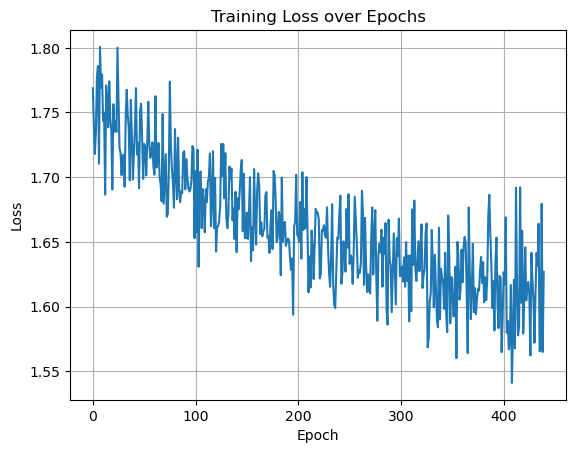

In [ ]:
plt.plot(train_losses)
plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


### II.4 Initializing with pre-trained embeddings:

Now, we would like to integrate pre-trained word embeddings into our model ! However, we need to not forget to add a vector for the padding symbol.

In [ ]:
def get_glove_adapted_embeddings(glove_model, input_voc):
    keys = {i: glove_model.key_to_index.get(w, None) for w, i in input_voc.items()}
    index_dict = {i: key for i, key in keys.items() if key is not None}
    # Important change here: add one supplementary word for padding
    embeddings = np.zeros((len(input_voc)+1,glove_model.vectors.shape[1]))
    for i, ind in index_dict.items():
        embeddings[i] = glove_model.vectors[ind]
    return embeddings

GloveEmbeddings = get_glove_adapted_embeddings(loaded_glove_model, training_word2idx)

In [ ]:
print(GloveEmbeddings.shape)

(11, 300)


Here, implement a ```PretrainedAveragingModel``` very similar to the previous model, using the ```nn.Embedding``` method ```from_pretrained()``` to initialize the embeddings from a numpy array. Use the ```requires_grad_``` method to specify if the model must fine-tune the embeddings or not !
<div class='alert alert-block alert-info'>
            Code:</div>

In [ ]:

class PretrainedAveragingModel(nn.Module):
    def __init__(self, pretrained_embeddings, output_dim, fine_tune=True):
        super().__init__()

        # Initialize embedding layer using from_pretrained
        self.embeddings = nn.Embedding.from_pretrained(
            pretrained_embeddings,            # should already be a FloatTensor
            freeze=not fine_tune,             # freeze if not fine-tuning
            padding_idx=0                     # padding index is 0
        )

        # Linear layer to map averaged embeddings to class logits
        self.linear = nn.Linear(pretrained_embeddings.shape[1], output_dim)

    def forward(self, inputs):
        # inputs shape: [batch_size, seq_len]
        x = self.embeddings(inputs)           # shape: [batch_size, seq_len, emb_dim]
        x = x.mean(dim=1)                     # mean over seq_len -> [batch_size, emb_dim]
        o = self.linear(x)                    # output logits -> [batch_size, output_dim]
        return o

In [ ]:

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


<div class='alert alert-block alert-warning'>
            Questions:</div>
            
- What are the results **with and without fine-tuning of embeddings imported from GloVe** ? Explain them.
- Look again at the confusion matrix these results in more details.

In [ ]:
model_pre_trained = PretrainedAveragingModel(
    torch.FloatTensor(GloveEmbeddings),
    max(ng_train_labels) + 1,
    True  # or False, depending on whether you want to fine-tune
)
opt_pre_trained = optim.Adam(model_pre_trained.parameters(), lr=0.0025, betas=(0.9, 0.999))

In [ ]:
train_losses = experiment(model_pre_trained, opt_pre_trained, criterion)

Beginning training...
Epoch 1:
Batch 0 : training loss = 1.7923663854599; training acc = 10.5
Batch 20 : training loss = 1.713869571685791; training acc = 28.5
Batch 40 : training loss = 1.7253624200820923; training acc = 19.5
Epoch 1 : Validation loss = 1.7063476771451114; Validation acc = 22.02247191011236
Epoch 2:
Batch 0 : training loss = 1.7173365354537964; training acc = 21.5
Batch 20 : training loss = 1.6777693033218384; training acc = 27.5
Batch 40 : training loss = 1.670546054840088; training acc = 28.5
Epoch 2 : Validation loss = 1.682047530506434; Validation acc = 30.1123595505618
Epoch 3:
Batch 0 : training loss = 1.7013311386108398; training acc = 23.0
Batch 20 : training loss = 1.6905467510223389; training acc = 30.5
Batch 40 : training loss = 1.6652919054031372; training acc = 20.0
Epoch 3 : Validation loss = 1.6556497919425537; Validation acc = 30.15730337078652
Epoch 4:
Batch 0 : training loss = 1.6377363204956055; training acc = 36.0
Batch 20 : training loss = 1.67729

In [ ]:
model_pre_trained_light = PretrainedAveragingModel(
    torch.FloatTensor(GloveEmbeddings),
    max(ng_train_labels) + 1,
    False
)

opt_pre_trained_light = optim.Adam(model_pre_trained_light.parameters(), lr=0.0025, betas=(0.9, 0.999))


In [ ]:
train_losses = experiment(model_pre_trained_light, opt_pre_trained_light, criterion)

Beginning training...
Epoch 1:
Batch 0 : training loss = 1.7932331562042236; training acc = 17.5
Batch 20 : training loss = 1.751266598701477; training acc = 22.5
Batch 40 : training loss = 1.72593355178833; training acc = 24.0
Epoch 1 : Validation loss = 1.7213893057255263; Validation acc = 23.59550561797753
Epoch 2:
Batch 0 : training loss = 1.712673306465149; training acc = 30.0
Batch 20 : training loss = 1.7134411334991455; training acc = 24.0
Batch 40 : training loss = 1.7026987075805664; training acc = 29.5
Epoch 2 : Validation loss = 1.6907660197675898; Validation acc = 30.247191011235955
Epoch 3:
Batch 0 : training loss = 1.7212607860565186; training acc = 23.5
Batch 20 : training loss = 1.6815555095672607; training acc = 25.0
Batch 40 : training loss = 1.6983205080032349; training acc = 32.5
Epoch 3 : Validation loss = 1.6716507941149594; Validation acc = 30.426966292134832
Epoch 4:
Batch 0 : training loss = 1.7005150318145752; training acc = 31.5
Batch 20 : training loss = 1.

In [ ]:
val_loss_finetuned, val_acc_finetuned = eval_model(model_pre_trained, criterion, valid_dataloader)
val_loss_frozen, val_acc_frozen = eval_model(model_pre_trained_light, criterion, valid_dataloader)

print(f"Accuracy with fine-tuning: {val_acc_finetuned:.2f}%")
print(f"Accuracy without fine-tuning: {val_acc_frozen:.2f}%")


Accuracy with fine-tuning: 32.45%
Accuracy without fine-tuning: 31.37%


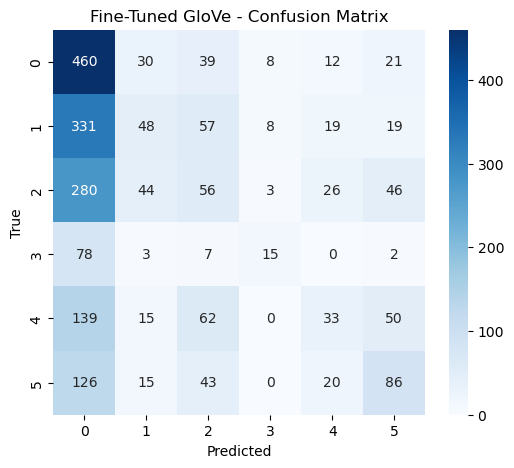

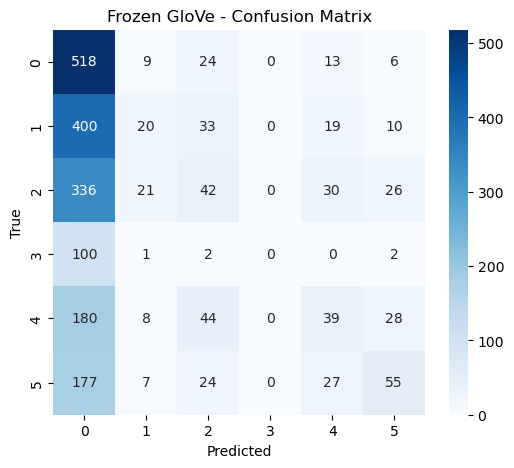

In [ ]:
# Get predictions
y_pred_finetuned = model_pre_trained(valid_dataset.tensor_data).argmax(dim=1)
y_pred_frozen = model_pre_trained_light(valid_dataset.tensor_data).argmax(dim=1)

# Plot
plot_confusion_matrix(valid_dataset.tensor_y, y_pred_finetuned, "Fine-Tuned GloVe - Confusion Matrix")
plot_confusion_matrix(valid_dataset.tensor_y, y_pred_frozen, "Frozen GloVe - Confusion Matrix")


* with fine-tuning the model achieves a slightly better accuracy (32,45%) compared to the without fine-tuning (31,37%) this small improvement shows that adapting pre-trained glove embeddings to our specific task gives us small increase in performance.
* from the confusion matrices we can see that fine-tuning helps reduce confusion especially in class 1 and 2 wich were more mixed in the frozen version. overall, results are expected and This suggests fine-tuning helps refine decision boundaries, even with simple models.

***
# let's try finetuning roberta

In [68]:
from transformers import (
    RobertaTokenizerFast,
    RobertaForSequenceClassification,
    Trainer,
    TrainingArguments
)
from datasets import Dataset

In [69]:
# train_texts_split, train_labels_split, val_texts, val_labels, ng_test_text, ng_test_labels

train_texts = [" ".join(t) for t in train_texts_split]
val_texts   = [" ".join(t) for t in val_texts]
test_texts  = [" ".join(t) for t in ng_test_text]

train_dataset = Dataset.from_dict({"text": train_texts, "label": train_labels_split})
val_dataset   = Dataset.from_dict({"text": val_texts,   "label": val_labels})
test_dataset  = Dataset.from_dict({"text": test_texts,  "label": ng_test_labels})


In [70]:
tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")

def tokenize(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=256)

train_dataset = train_dataset.map(tokenize, batched=True)
val_dataset   = val_dataset.map(tokenize, batched=True)
test_dataset  = test_dataset.map(tokenize, batched=True)

train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])
val_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Map:   0%|          | 0/8800 [00:00<?, ? examples/s]

Map:   0%|          | 0/2201 [00:00<?, ? examples/s]

Map:   0%|          | 0/7317 [00:00<?, ? examples/s]

In [71]:
num_labels = 6
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=num_labels)


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [78]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    logging_dir="./logs",
    report_to="none"
)


In [79]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="macro")
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)


/tmp/ipython-input-3465506934.py:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [80]:
trainer.train()

TrainOutput(global_step=1650, training_loss=0.5060218579841382, metrics={'train_runtime': 1399.1889, 'train_samples_per_second': 18.868, 'train_steps_per_second': 1.179, 'total_flos': 3473190663782400.0, 'train_loss': 0.5060218579841382, 'epoch': 3.0})

In [81]:
def evaluate_and_plot(dataset, y_true, title):
    preds = trainer.predict(dataset)
    y_pred = np.argmax(preds.predictions, axis=-1)

    print(f"\n===== {title} =====")
    print(classification_report(y_true, y_pred, digits=4))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
    plt.title(f"Confusion Matrix - {title}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


***


===== Train Set =====
              precision    recall  f1-score   support

           0     0.9120    0.9685    0.9394      2289
           1     0.9164    0.9440    0.9300      1822
           2     0.9299    0.8583    0.8927      1856
           3     0.8676    0.8750    0.8713       472
           4     0.8996    0.8872    0.8933      1232
           5     0.9311    0.8973    0.9138      1129

    accuracy                         0.9147      8800
   macro avg     0.9094    0.9050    0.9068      8800
weighted avg     0.9150    0.9147    0.9142      8800



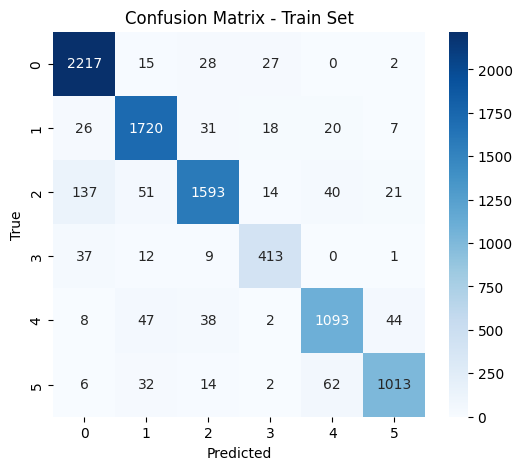

In [82]:
evaluate_and_plot(train_dataset, train_labels_split, "Train Set")

***


===== Test Set =====
              precision    recall  f1-score   support

           0     0.8397    0.9320    0.8834      1911
           1     0.8430    0.8892    0.8655      1534
           2     0.8354    0.7564    0.7939      1523
           3     0.8919    0.7775    0.8308       382
           4     0.8072    0.7868    0.7968      1027
           5     0.8659    0.7968    0.8299       940

    accuracy                         0.8406      7317
   macro avg     0.8472    0.8231    0.8334      7317
weighted avg     0.8410    0.8406    0.8393      7317



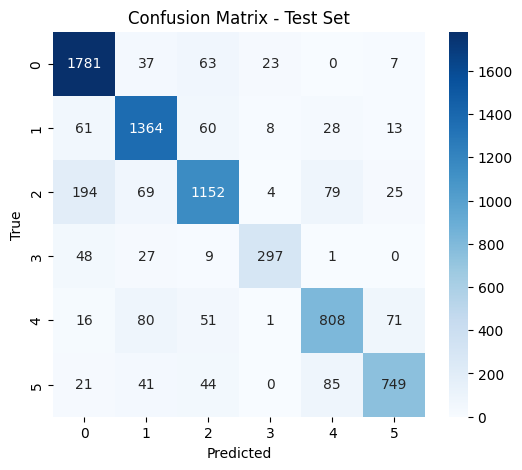

In [84]:
evaluate_and_plot(test_dataset, ng_test_labels, "Test Set")